In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation, Conv1D, GlobalMaxPooling1D, MaxPooling1D
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model

import datetime
import os

Using TensorFlow backend.


In [2]:
### 데이터 로드
data = pd.read_csv('dataset/PM_2.5_dataset_with_china.csv', index_col=0)
data.head()

,PM Seoul,PM Beijing,temprature,humidity,max wind speed,wind direction
date,,,,,,
2009-01-01,43.739130,181.083875,-5.8,45.8,4.5,290.0
2009-01-02,45.750000,168.780998,-2.8,51.5,3.7,230.0
2009-01-03,46.833333,177.560185,-1.0,48.3,3.9,250.0
2009-01-04,40.083333,169.828704,0.4,44.3,4.3,290.0
2009-01-05,58.541667,140.598765,-1.6,53.1,4.5,270.0


In [3]:
## 정규화 함수
def normalize_windows(data):
    normalized_data = []
    head = []

    for window in data:
        head.append(window[0])
        normalized_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalized_data.append(normalized_window)
        
    return np.array(normalized_data), head

In [4]:
### 데이터 전처리
## PM in Seoul
pm_seoul_data = data['PM Seoul'].values

seq_len = 30
sequence_length = seq_len + 1

pm_seoul = []
for index in range(len(pm_seoul_data) - sequence_length):
    pm_seoul.append(pm_seoul_data[index: index + sequence_length])
    
norm_pm_seoul, head_pm_seoul = normalize_windows(pm_seoul)
print(norm_pm_seoul[0])
print(head_pm_seoul[0])

[ 0.          0.04597416  0.07074221 -0.08358184  0.33842777  1.19483101
  0.90047217  0.65088635  0.4917992   0.23649768 -0.05119284  0.20982439
 -0.0273774   0.42702121 -0.11787608  0.22982936  1.15196322  1.48156892
  0.8699884   0.10884692  0.28317594  0.39463221  0.68899105  0.01358516
  0.07360007 -0.2436216   0.04121107  0.04216368  0.34128562 -0.11501822
 -0.50940192]
43.73913043


In [5]:
## PM in Beijing

pm_beijing_data = data['PM Beijing'].values

seq_len = 30
sequence_length = seq_len + 1

pm_beijing = []
for index in range(len(pm_beijing_data) - sequence_length):
    pm_beijing.append(pm_beijing_data[index: index + sequence_length])
    
norm_pm_beijing, _ = normalize_windows(pm_beijing)
print(norm_pm_beijing[0])

[ 0.         -0.06794021 -0.01945888 -0.06215446 -0.22357103 -0.22063944
 -0.15928163 -0.2274784  -0.2962978  -0.08491173 -0.264351   -0.09472471
 -0.02810137 -0.01346105 -0.03739358  0.10157812 -0.01731132  0.01541344
  0.14535096 -0.32149817 -0.36548833 -0.23604568 -0.02456872 -0.38444155
 -0.30538159 -0.10766233 -0.12031761 -0.05570726 -0.20190052 -0.32625348
 -0.31031843]


In [6]:
## temprature data
temprature_data = data['temprature'].values
delta = 1e-7
for i in range(len(temprature_data)):
    if temprature_data[i] == 0:
        temprature_data[i] = temprature_data[i]+delta

temprature = []
for index in range(len(temprature_data) - sequence_length):
    temprature.append(temprature_data[index: index + sequence_length])
    
norm_temprature, _ = normalize_windows(temprature)
print(norm_temprature[0])

[ 0.         -0.51724138 -0.82758621 -1.06896552 -0.72413793 -0.65517241
 -0.9137931  -0.84482759 -0.39655172  0.29310345  0.37931034  0.34482759
 -0.05172414  0.13793103  0.0862069  -0.51724138 -0.75862069 -1.44827586
 -1.10344828 -1.37931034 -1.67241379 -1.62068966  0.55172414  0.39655172
 -0.20689655 -0.43103448 -0.67241379 -1.25862069 -1.56896552 -2.
 -2.05172414]


In [7]:
## humidity data
humidity_data = data['humidity'].values

humidity = []
for index in range(len(humidity_data) - sequence_length):
    humidity.append(humidity_data[index: index + sequence_length])
    
norm_humidity, _ = normalize_windows(humidity)
print(norm_humidity[0])

[ 0.          0.12445415  0.05458515 -0.03275109  0.15938865  0.09170306
 -0.08296943 -0.08296943 -0.06113537 -0.08296943 -0.13755459  0.0371179
 -0.01091703 -0.13537118 -0.2489083   0.76419214  0.6768559   0.56768559
  0.04803493 -0.33842795  0.17030568  0.34497817 -0.15720524  0.37336245
  0.4279476   0.3930131   0.15283843 -0.08078603 -0.19213974  0.01746725
  0.10043668]


In [8]:
## wind data
wind_speed_data = data['max wind speed'].values

wind_speed = []
for index in range(len(wind_speed_data) - sequence_length):
    wind_speed.append(wind_speed_data[index: index + sequence_length])
    
norm_wind_speed, _ = normalize_windows(wind_speed)
print(norm_wind_speed[0])

[ 0.         -0.17777778 -0.13333333 -0.04444444  0.         -0.31111111
 -0.11111111 -0.06666667  0.02222222  0.11111111  0.62222222  0.48888889
 -0.08888889  0.31111111 -0.15555556 -0.28888889 -0.22222222  0.35555556
  0.35555556 -0.26666667  0.08888889  0.8         0.77777778  0.31111111
  0.55555556  0.24444444 -0.13333333 -0.26666667 -0.31111111  0.22222222
  0.02222222]


In [9]:
## wind direction data
wind_direction_data = data['wind direction'].values

wind_direction = []
for index in range(len(wind_direction_data) - sequence_length):
    wind_direction.append(wind_direction_data[index: index + sequence_length])
    
norm_wind_direction, _ = normalize_windows(wind_direction)
print(norm_wind_direction[0])

[ 0.         -0.20689655 -0.13793103  0.         -0.06896552  0.
  0.          0.          0.         -0.06896552  0.         -0.06896552
  0.          0.         -0.13793103 -0.82758621 -0.82758621 -0.06896552
 -0.06896552  0.         -0.31034483 -0.06896552  0.         -0.13793103
 -0.13793103 -0.06896552 -0.13793103 -0.75862069 -0.06896552 -0.75862069
 -0.82758621]


In [10]:
def marge_data(a, b, c, d, e, f):
    marged_data = []
    marge = []
    
    for a_index, b_index, c_index, d_index, e_index, f_index in zip(a, b, c, d, e, f):
        for i in range(len(a_index)):
            marge.append(a_index[i])
            marge.append(b_index[i])
            #marge.append(c_index[i])
            #marge.append(d_index[i])
            #marge.append(e_index[i])
            #marge.append(f_index[i])
            
        for i in range(1):
            marge.pop()
        
        marged_data.append(marge)
        marge = []
    
    return np.array(marged_data)

norm_result = marge_data(norm_pm_seoul, norm_pm_beijing, norm_temprature, norm_humidity, norm_wind_speed, norm_wind_direction)
print(norm_result[0])

[ 0.          0.          0.04597416 -0.06794021  0.07074221 -0.01945888
 -0.08358184 -0.06215446  0.33842777 -0.22357103  1.19483101 -0.22063944
  0.90047217 -0.15928163  0.65088635 -0.2274784   0.4917992  -0.2962978
  0.23649768 -0.08491173 -0.05119284 -0.264351    0.20982439 -0.09472471
 -0.0273774  -0.02810137  0.42702121 -0.01346105 -0.11787608 -0.03739358
  0.22982936  0.10157812  1.15196322 -0.01731132  1.48156892  0.01541344
  0.8699884   0.14535096  0.10884692 -0.32149817  0.28317594 -0.36548833
  0.39463221 -0.23604568  0.68899105 -0.02456872  0.01358516 -0.38444155
  0.07360007 -0.30538159 -0.2436216  -0.10766233  0.04121107 -0.12031761
  0.04216368 -0.05570726  0.34128562 -0.20190052 -0.11501822 -0.32625348
 -0.50940192]


In [11]:
# train_cut = -90 # 마지막 3달의 데이터를 test데이터로 한다
train_cut = int(round(norm_result.shape[0] * 0.7))

valid_cut = -365
        
train = norm_result[:train_cut, :]
np.random.shuffle(train)

valid = norm_result[train_cut:valid_cut, :]

test = norm_result[valid_cut:, :]

x_train = train[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:,-1]
y_train = np.reshape(y_train, (y_train.shape[0], 1))

x_valid = valid[:, :-1]
x_valid = np.reshape(x_valid, (x_valid.shape[0], x_valid.shape[1], 1))
y_valid = valid[:,-1]
y_valid = np.reshape(y_valid, (y_valid.shape[0], 1))

x_test = norm_result[valid_cut:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = norm_result[valid_cut:,-1]
y_test = np.reshape(y_test, (y_test.shape[0], 1))

print(x_train.shape, x_valid.shape, x_test.shape)
print(y_train.shape, y_valid.shape, y_test.shape)

(2535, 60, 1) (721, 60, 1) (365, 60, 1)
(2535, 1) (721, 1) (365, 1)


In [11]:
### 모델 체크포인터 롤백
MODEL_SAVE_FOLBER_PATH = './model/checkpoint_archi_5/'
if not os.path.exists(MODEL_SAVE_FOLBER_PATH):
    os.mkdir(MODEL_SAVE_FOLBER_PATH)
    
model_path = MODEL_SAVE_FOLBER_PATH + '{epoch:02d}-{val_loss:.4f}.hdf5'

# 체크포인트 생성 코드
cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss',verbose=1, save_best_only=True, mode='auto')

In [13]:
### 학습 모델 로드

model = load_model('model/pm_prediction_model_achi_2_beijing.h5')

W1025 13:34:34.796786 27168 deprecation_wrapper.py:119] From D:\_setup\anaconda3\envs\py3.7\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1025 13:34:34.814780 27168 deprecation_wrapper.py:119] From D:\_setup\anaconda3\envs\py3.7\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1025 13:34:34.832772 27168 deprecation_wrapper.py:119] From D:\_setup\anaconda3\envs\py3.7\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1025 13:34:35.432581 27168 deprecation_wrapper.py:119] From D:\_setup\anaconda3\envs\py3.7\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W1025 13:34:35.433581 27168 depr

In [12]:
### VCRNN 모델 설계
model = Sequential()


model.add(Conv1D(60, 2, activation='relu',strides=2, input_shape=(60,1)))
model.add(Conv1D(60, 2, activation='relu',strides=1, padding="same"))
# model.add(Conv1D(60, 3, activation='relu',strides=1, padding="same"))

for i in range (3):
    model.add(LSTM(60, return_sequences=True))
    model.add(Dropout(0.5))

model.add(LSTM(30, return_sequences=False))

model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='Nadam')

model.summary()

W1025 14:33:56.913018 10020 deprecation_wrapper.py:119] From D:\_setup\anaconda3\envs\py3.7\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1025 14:33:56.929014 10020 deprecation_wrapper.py:119] From D:\_setup\anaconda3\envs\py3.7\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1025 14:33:56.931013 10020 deprecation_wrapper.py:119] From D:\_setup\anaconda3\envs\py3.7\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1025 14:33:57.096969 10020 deprecation_wrapper.py:119] From D:\_setup\anaconda3\envs\py3.7\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W1025 14:33:57.102959 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 30, 60)            180       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 30, 60)            7260      
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 60)            29040     
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 60)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 60)            29040     
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 60)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 30, 60)            29040     
__________

In [13]:
### 모델 학습
start_time = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')

hist = model.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=30, batch_size=61)
# hist = model.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=30, batch_size=64, callbacks=[cb_checkpoint])

W1025 14:34:04.597551 10020 deprecation.py:323] From D:\_setup\anaconda3\envs\py3.7\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W1025 14:34:06.426015 10020 deprecation_wrapper.py:119] From D:\_setup\anaconda3\envs\py3.7\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 2535 samples, validate on 721 samples
Epoch 1/30
2535/2535 [==============================] - 13s 5ms/step - loss: 0.9511 - val_loss: 0.4385
Epoch 2/30
2535/2535 [==============================] - 9s 3ms/step - loss: 0.8124 - val_loss: 0.4142
Epoch 3/30
2535/2535 [==============================] - 8s 3ms/step - loss: 0.8176 - val_loss: 0.4279
Epoch 4/30
2535/2535 [==============================] - 8s 3ms/step - loss: 0.7735 - val_loss: 0.3890
Epoch 5/30
2535/2535 [==============================] - 8s 3ms/step - loss: 0.7410 - val_loss: 0.3597
Epoch 6/30
2535/2535 [==============================] - 8s 3ms/step - loss: 0.7385 - val_loss: 0.3485
Epoch 7/30
2535/2535 [==============================] - 8s 3ms/step - loss: 0.6609 - val_loss: 0.4076
Epoch 8/30
2535/2535 [==============================] - 8s 3ms/step - loss: 0.6156 - val_loss: 0.3344
Epoch 9/30
2535/2535 [==============================] - 9s 3ms/step - loss: 0.5822 - val_loss: 0.3851
Epoch 10/30
2535/2535 [===========

In [14]:
## 모델 저장
model.save('model/pm_prediction_model_achi_2_beijing.h5')

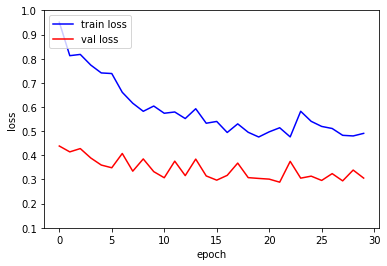

In [15]:
## 손실함수 변화 측정

%matplotlib inline

fig, loss_ax = plt.subplots()

#acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'b', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([0.1, 1.0])


#acc_ax.plot(hist.history['acc'], 'b', label='train acc')
#acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')
#acc_ax.set_ylim([0.25, 1.0])

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
#acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='upper left')
#acc_ax.legend(loc='lower left')

plt.show()

In [16]:
# 실제 데이터화
test_head_data = head_pm_seoul[valid_cut:]

y_actual = []
for i in range(-valid_cut):
    temp = test_head_data[i]*(y_test[i]+1)
    y_actual.append(temp.tolist())
    
y_true = sum(y_actual,[])

In [17]:
pred = model.predict(x_test)

y_pred = []
for i in range(-valid_cut):
    temp = test_head_data[i]*(pred[i]+1)
    y_pred.append(temp.tolist())
    
y_pred = sum(y_pred,[])

D:\_setup\anaconda3\envs\py3.7\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


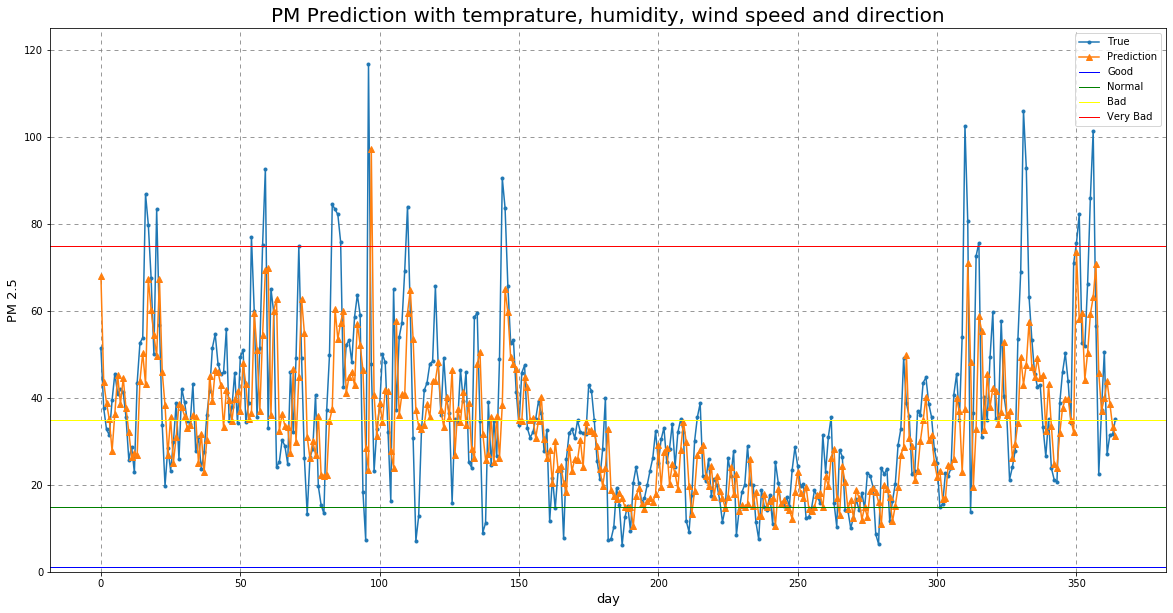

In [18]:
pred = model.predict(x_test)

fig = plt.figure(facecolor='white', figsize=(20, 10))

plt.title('PM Prediction with temprature, humidity, wind speed and direction', fontsize=20)

ax = fig.add_subplot(111)
ax.plot(y_true, label='True', marker='.')
ax.plot(y_pred, label='Prediction', marker='^')

plt.grid(color='gray', dashes=(5,5))

plt.axhline(y=1, color='blue', linewidth=1, label='Good')
plt.axhline(y=15, color='green', linewidth=1, label='Normal')
plt.axhline(y=35, color='yellow', linewidth=1, label='Bad')
plt.axhline(y=75, color='red', linewidth=1, label='Very Bad')

plt.xlabel('day', fontsize=13)
plt.ylabel('PM 2.5', fontsize=13)

plt.ylim([0, 125])

ax.legend()
plt.show()

In [19]:
def pm_level(pm):
    level_1 = 15
    level_2 = 35
    level_3 = 75
    
    level_temp = []
    
    for i in range(len(pm)):
        if pm[i] <= level_1:
            level_temp.append(1)
        elif pm[i] <= level_2:
            level_temp.append(2)
        elif pm[i] <= level_3:
            level_temp.append(3)
        else:
            level_temp.append(4)
            
    return level_temp
    

In [20]:
def error_check(true, pred):
    y_true_lv = pm_level(true)
    y_pred_lv = pm_level(pred)
    
    level_1_acc = 0
    level_2_acc = 0
    level_3_acc = 0
    level_4_acc = 0

    level_1_count = y_true_lv.count(1)
    level_2_count = y_true_lv.count(2)
    level_3_count = y_true_lv.count(3)
    level_4_count = y_true_lv.count(4)
            
    
    error_rate_temp = []
    
    for i in range(len(y_pred_lv)):
        if y_pred_lv[i] == y_true_lv[i]:
            error_rate_temp.append(1)
            
            if y_pred_lv[i] == 1:
                level_1_acc += 1
            elif y_pred_lv[i] == 2:
                level_2_acc += 1
            elif y_pred_lv[i] == 3:
                level_3_acc += 1
            else:
                level_4_acc += 1
                    
        else:
            error_rate_temp.append(0)
    
    total_acc = sum(error_rate_temp) / len(error_rate_temp)
    
    level_1_accuracy = float(level_1_acc / level_1_count)
    level_2_accuracy = float(level_2_acc / level_2_count)
    level_3_accuracy = float(level_3_acc / level_3_count)
    level_4_accuracy = float(level_4_acc / level_4_count)
    
    level_accuracy = [level_1_accuracy, level_2_accuracy, level_3_accuracy, level_4_accuracy]
    
    return total_acc, level_accuracy


In [21]:
total_acc, level_acc = error_check(y_true, y_pred)
print("total accuracy:", total_acc)
print("level 'Good' accuracy:", level_acc[0])
print("level 'Normal' accuracy:", level_acc[1])
print("level 'Bad' accuracy:", level_acc[2])
print("level 'Veray Bad' accuracy:", level_acc[3])

total accuracy: 0.5726027397260274
level 'Good' accuracy: 0.2619047619047619
level 'Normal' accuracy: 0.676829268292683
level 'Bad' accuracy: 0.6397058823529411
level 'Veray Bad' accuracy: 0.0


In [22]:
pred_error = abs((pred-y_test) / y_test)

total_error_rate = sum(pred_error)/len(pred_error)
print("Direct total error rate: ", total_error_rate)

Direct total error rate:  [2.17919176]
